## Task 1: Basics (Clean Evaluation)

We evaluate a pre-trained **ResNet-34** model on a clean test set of 100 ImageNet classes.

- Dataset is normalized using standard ImageNet mean and std
- Labels are mapped using the provided `.json` file
- Compute **Top-1** and **Top-5** accuracy

This establishes the baseline performance before applying adversarial attacks.


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os, json, random
import os
from torchvision.utils import save_image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval().cuda()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 222MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

In [5]:
dataset_path = "/content/drive/MyDrive/TestDataSet"

test_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
json_path = "/content/drive/MyDrive/TestDataSet/labels_list.json"
with open(json_path, "r") as f:
    index_map = json.load(f)

imagenet_labels = {i: int(entry.split(":")[0]) for i, entry in enumerate(index_map)}

In [7]:
def evaluate_model(model, dataloader, imagenet_labels):
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, top5_preds = outputs.topk(5, dim=1)

            true_labels = torch.tensor([imagenet_labels[int(lbl)] for lbl in labels]).cuda()

            top1_correct += (top5_preds[:, 0] == true_labels).sum().item()
            top5_correct += sum([true_labels[i] in top5_preds[i] for i in range(len(labels))])
            total += labels.size(0)

    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total
    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")

In [8]:
evaluate_model(model, test_loader, imagenet_labels)

100%|██████████| 16/16 [06:40<00:00, 25.02s/it]

Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


In [9]:
def evaluate_adv(model, adv_images, dataloader, imagenet_labels, label="ADV"):
    top1_correct = 0
    top5_correct = 0
    total = 0
    idx = 0

    with torch.no_grad():
        for _, labels in dataloader:
            true_labels = torch.tensor([imagenet_labels[int(lbl)] for lbl in labels]).cuda()
            batch_size = len(labels)

            inputs = torch.stack(adv_images[idx:idx + batch_size]).cuda()
            outputs = model(inputs)
            _, top5_preds = outputs.topk(5, dim=1)

            top1_correct += (top5_preds[:, 0] == true_labels).sum().item()
            top5_correct += sum([true_labels[i] in top5_preds[i] for i in range(batch_size)])
            total += batch_size
            idx += batch_size

    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total
    print(f"[{label}] Top-1: {top1_acc:.2f}%, Top-5: {top5_acc:.2f}%")

In [10]:
def show_adversarial_examples(loader, adversarial_tensor, count=5, title="Attack Comparison"):
    orig_images, _ = next(iter(loader))
    plt.figure(figsize=(15, 4))

    for i in range(count):
        orig = orig_images[i].permute(1, 2, 0).cpu().numpy()
        adv = adversarial_tensor[i].permute(1, 2, 0).cpu().numpy()
        diff = (adv - orig) * 5  # amplify diff for visibility

        plt.subplot(3, count, i + 1)
        plt.imshow(orig)
        plt.axis("off")
        plt.title("Original")

        plt.subplot(3, count, i + 1 + count)
        plt.imshow(adv)
        plt.axis("off")
        plt.title("Adversarial")

        plt.subplot(3, count, i + 1 + 2 * count)
        plt.imshow(abs(diff))
        plt.axis("off")
        plt.title("Diff ×5")

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()

In [11]:
def save_adversarial_images(tensor, folder, attack_name):
    os.makedirs(folder, exist_ok=True)
    for idx in range(min(500, len(tensor))):
        filename = f"{attack_name.upper()}_{idx:03d}.png"
        path = os.path.join(folder, filename)
        save_image(tensor[idx], path)

## Task 2: FGSM Attack (Adversarial Test Set 1)

In this task, we generate adversarial examples using the **Fast Gradient Sign Method (FGSM)** with an $L_\infty$ constraint of **ε = 0.02**.

- The attack is applied to the **raw pixel space** and then re-normalized.
- We ensure the adversarial images remain visually indistinguishable.
- 500 adversarial examples are saved as **Adversarial Test Set 1**.
- The goal is to drop model accuracy by at least 50%.

We also visualize and evaluate the attack performance on ResNet-34.

In [13]:
def fgsm_attack_raw(model, images, labels, epsilon=0.02):
    # De-normalize
    mean = torch.tensor(mean_norms).reshape(1, 3, 1, 1).to(images.device)
    std = torch.tensor(std_norms).reshape(1, 3, 1, 1).to(images.device)
    raw = images * std + mean
    raw.requires_grad = True

    # Forward pass with normalized input
    normalized = (raw - mean) / std
    outputs = model(normalized)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Apply FGSM in raw pixel space
    perturbation = epsilon * raw.grad.sign()
    adv_raw = torch.clamp(raw + perturbation, 0, 1)

    # Measure L-infinity distance between raw and perturbed image
    l_inf_values = []
    for i in range(images.shape[0]):
        raw_img = raw[i]
        adv_img = adv_raw[i]
        l_inf = (adv_img - raw_img).abs().max().item()
        l_inf_values.append(l_inf)

    # Report stats
    print(f"L∞ max: {max(l_inf_values):.5f}, mean: {sum(l_inf_values)/len(l_inf_values):.5f}")

    # Re-normalize before feeding to model
    adv_norm = (adv_raw - mean) / std
    return adv_norm.detach()

# Generate and evaluate FGSM adversarial examples
fgsm_adv_raw = []
for images, labels in tqdm(test_loader, desc="FGSM"):
    images, labels = images.cuda(), labels.cuda()
    mapped_labels = torch.tensor([imagenet_labels[int(lbl)] for lbl in labels]).cuda()
    adv = fgsm_attack_raw(model, images, mapped_labels)
    fgsm_adv_raw.extend(adv.cpu())

# Evaluate model on FGSM adversarial examples
evaluate_adv(model, fgsm_adv_raw, test_loader, imagenet_labels)

FGSM:  12%|█▎        | 2/16 [00:00<00:04,  3.46it/s]

L∞ max: 0.02000, mean: 0.02000
L∞ max: 0.02000, mean: 0.02000


FGSM:  25%|██▌       | 4/16 [00:00<00:02,  5.62it/s]

L∞ max: 0.02000, mean: 0.02000
L∞ max: 0.02000, mean: 0.02000


FGSM:  38%|███▊      | 6/16 [00:01<00:01,  6.90it/s]

L∞ max: 0.02000, mean: 0.02000
L∞ max: 0.02000, mean: 0.02000


FGSM:  50%|█████     | 8/16 [00:01<00:01,  7.54it/s]

L∞ max: 0.02000, mean: 0.02000
L∞ max: 0.02000, mean: 0.02000


FGSM:  62%|██████▎   | 10/16 [00:01<00:00,  7.88it/s]

L∞ max: 0.02000, mean: 0.02000
L∞ max: 0.02000, mean: 0.02000


FGSM:  75%|███████▌  | 12/16 [00:01<00:00,  8.28it/s]

L∞ max: 0.02000, mean: 0.02000
L∞ max: 0.02000, mean: 0.02000


FGSM:  88%|████████▊ | 14/16 [00:02<00:00,  8.28it/s]

L∞ max: 0.02000, mean: 0.02000
L∞ max: 0.02000, mean: 0.02000


FGSM: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]

L∞ max: 0.02000, mean: 0.02000
L∞ max: 0.02000, mean: 0.02000


[ADV] Top-1: 3.80%, Top-5: 21.00%


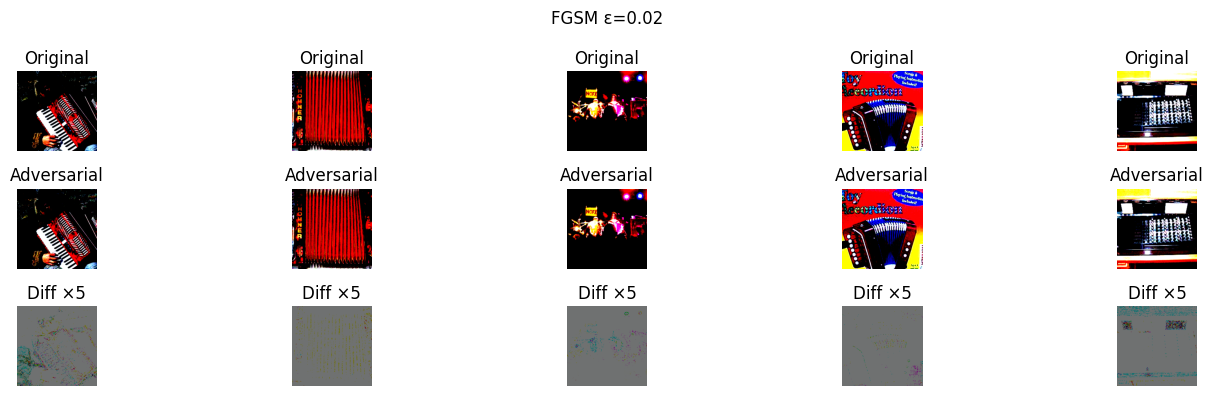

In [14]:
show_adversarial_examples(test_loader, fgsm_adv_raw, title="FGSM ε=0.02")

In [15]:
save_adversarial_images(fgsm_adv_raw, "AdversarialTestSet1", "fgsm")

## Task 3: PGD Attack (Adversarial Test Set 2)

Here, we implement **Projected Gradient Descent (PGD)** with the same $L_\infty$ bound of **ε = 0.02**, using 15 steps.

- PGD is a stronger multi-step variant of FGSM.
- Like Task 1, the attack is computed in raw pixel space and re-normalized.
- 500 adversarial examples are saved as **Adversarial Test Set 2**.
- We evaluate and visualize the attack on ResNet-34.

In [16]:
def pgd_attack_raw(model, images, labels, epsilon=0.02, steps=15):
    mean = torch.tensor(mean_norms).reshape(1, 3, 1, 1).to(images.device)
    std = torch.tensor(std_norms).reshape(1, 3, 1, 1).to(images.device)

    raw = images * std + mean  # De-normalize
    adv = raw.clone().detach().requires_grad_(True)
    alpha = epsilon / steps

    for _ in range(steps):
        normalized = (adv - mean) / std
        outputs = model(normalized)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()

        adv.data = adv + alpha * adv.grad.sign()
        adv.data = torch.max(torch.min(adv, raw + epsilon), raw - epsilon)  # Project to ε-ball
        adv.data = torch.clamp(adv, 0, 1).detach()
        adv.requires_grad = True

    # Compute L-infinity distance
    l_inf_values = []
    for i in range(images.shape[0]):
        raw_img = raw[i]
        adv_img = adv[i]
        l_inf = (adv_img - raw_img).abs().max().item()
        l_inf_values.append(l_inf)
    print(f"L∞ max: {max(l_inf_values):.5f}, mean: {sum(l_inf_values)/len(l_inf_values):.5f}")

    # Final normalized adversarial image
    adv_norm = (adv - mean) / std
    return adv_norm.detach()

# Apply PGD attack and evaluate
pgd_adv = []
for images, labels in tqdm(test_loader, desc="PGD (Raw Space)"):
    images, labels = images.cuda(), labels.cuda()
    mapped_labels = torch.tensor([imagenet_labels[int(lbl)] for lbl in labels]).cuda()
    adv_images = pgd_attack_raw(model, images, mapped_labels)
    pgd_adv.extend(adv_images.cpu())

evaluate_adv(model, pgd_adv, test_loader, imagenet_labels)

PGD (Raw Space):   6%|▋         | 1/16 [00:00<00:07,  2.13it/s]

L∞ max: 0.02000, mean: 0.02000


PGD (Raw Space):  12%|█▎        | 2/16 [00:00<00:06,  2.23it/s]

L∞ max: 0.02000, mean: 0.02000


PGD (Raw Space):  19%|█▉        | 3/16 [00:01<00:05,  2.31it/s]

L∞ max: 0.02000, mean: 0.02000


PGD (Raw Space):  25%|██▌       | 4/16 [00:01<00:05,  2.32it/s]

L∞ max: 0.02000, mean: 0.02000


PGD (Raw Space):  31%|███▏      | 5/16 [00:02<00:04,  2.34it/s]

L∞ max: 0.02000, mean: 0.02000


PGD (Raw Space):  38%|███▊      | 6/16 [00:02<00:04,  2.35it/s]

L∞ max: 0.02000, mean: 0.02000


PGD (Raw Space):  44%|████▍     | 7/16 [00:03<00:03,  2.34it/s]

L∞ max: 0.02000, mean: 0.02000


PGD (Raw Space):  50%|█████     | 8/16 [00:03<00:03,  2.34it/s]

L∞ max: 0.02000, mean: 0.02000


PGD (Raw Space):  56%|█████▋    | 9/16 [00:03<00:03,  2.33it/s]

L∞ max: 0.02000, mean: 0.02000


PGD (Raw Space):  62%|██████▎   | 10/16 [00:04<00:02,  2.35it/s]

L∞ max: 0.02000, mean: 0.02000


PGD (Raw Space):  69%|██████▉   | 11/16 [00:04<00:02,  2.32it/s]

L∞ max: 0.02000, mean: 0.02000


PGD (Raw Space):  75%|███████▌  | 12/16 [00:05<00:01,  2.34it/s]

L∞ max: 0.02000, mean: 0.02000


PGD (Raw Space):  81%|████████▏ | 13/16 [00:05<00:01,  2.33it/s]

L∞ max: 0.02000, mean: 0.02000


PGD (Raw Space):  88%|████████▊ | 14/16 [00:06<00:00,  2.35it/s]

L∞ max: 0.02000, mean: 0.02000


PGD (Raw Space):  94%|█████████▍| 15/16 [00:06<00:00,  2.35it/s]

L∞ max: 0.02000, mean: 0.02000


PGD (Raw Space): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

L∞ max: 0.02000, mean: 0.02000


[ADV] Top-1: 0.00%, Top-5: 1.40%


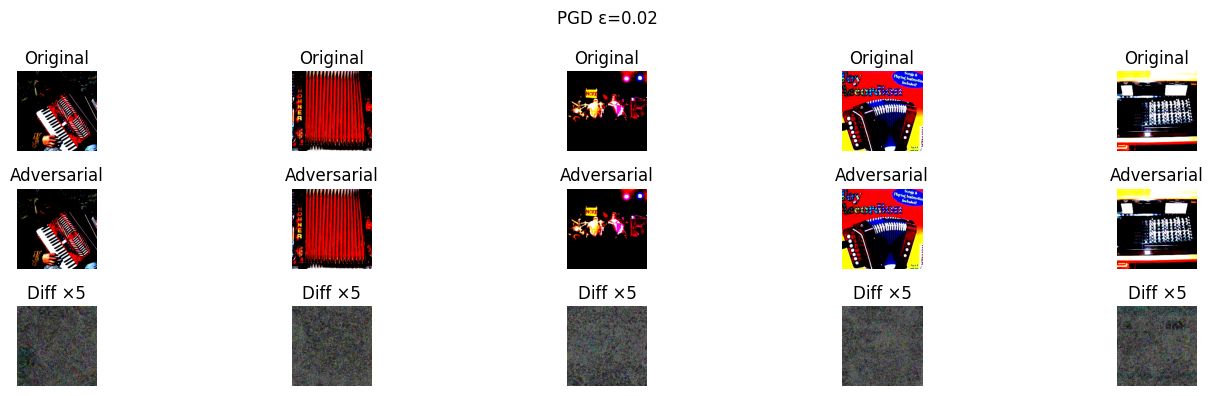

In [17]:
show_adversarial_examples(test_loader, pgd_adv, title="PGD ε=0.02")

In [18]:
save_adversarial_images(pgd_adv, "AdversarialTestSet2", "pgd")

## Task 4: Patch Attacks (Adversarial Test Set 3)

In this task, we perform **localized adversarial patch attacks**, both:
- **Untargeted**: maximize misclassification
- **Targeted**: steer model to a specific (wrong) class

Key details:
- Patch size: **32×32 pixels**
- Epsilon values tested: **0.3** and **0.5**
- Patches are randomly placed and iteratively optimized
- 500 examples (ε = 0.5) are saved as **Adversarial Test Set 3**

We visualize the patched images and report accuracy.

In [20]:
import torch
import torch.nn as nn
import random
from tqdm import tqdm

# Define patch size as per task
PATCH_SIZE = 32

# Helper: Generate random target labels ≠ true labels
def get_target_labels(true_labels, num_classes=1000):
    targets = []
    for label in true_labels:
        choices = list(range(num_classes))
        choices.remove(label.item())
        targets.append(random.choice(choices))
    return torch.tensor(targets, device=true_labels.device)

# Targeted patch attack
def targeted_patch_attack(model, images, true_labels, epsilon, steps=70):
    alpha = epsilon / steps
    mean = torch.tensor(mean_norms).reshape(1, 3, 1, 1).to(images.device)
    std = torch.tensor(std_norms).reshape(1, 3, 1, 1).to(images.device)

    raw = images * std + mean
    raw_orig = raw.clone().detach()
    _, _, H, W = raw.shape

    adv = raw.clone().detach()
    adv.requires_grad_()
    adv.retain_grad()

    target_labels = get_target_labels(true_labels)

    for step in range(steps):
        # Change patch every step
        top = random.randint(0, H - PATCH_SIZE)
        left = random.randint(0, W - PATCH_SIZE)

        norm_input = (adv - mean) / std
        outputs = model(norm_input)
        loss = -nn.CrossEntropyLoss()(outputs, target_labels)  # stronger targeted attack

        model.zero_grad()
        loss.backward(retain_graph=True)

        grad = adv.grad
        grad_patch = grad[:, :, top:top+PATCH_SIZE, left:left+PATCH_SIZE]

        update = 2 * alpha * grad_patch.sign()  # amplify gradient impact

        patch = adv[:, :, top:top+PATCH_SIZE, left:left+PATCH_SIZE] + update
        orig_patch = raw_orig[:, :, top:top+PATCH_SIZE, left:left+PATCH_SIZE]

        clipped_patch = torch.clamp(patch, orig_patch - epsilon, orig_patch + epsilon)
        clipped_patch = torch.clamp(clipped_patch, 0, 1)

        adv_new = adv.detach().clone()
        adv_new[:, :, top:top+PATCH_SIZE, left:left+PATCH_SIZE] = clipped_patch
        adv_new.requires_grad_()
        adv_new.retain_grad()
        adv = adv_new

    return ((adv - mean) / std).detach()

# Wrapper to run the attack and save results
def generate_targeted_patch_attacks(epsilon, save_path="adv_test_set_3.pt"):
    adv_images = []
    for images, labels in tqdm(test_loader, desc=f"Targeted Patch ε={epsilon}"):
        images = images.cuda()
        mapped_labels = torch.tensor([imagenet_labels[int(lbl)] for lbl in labels]).cuda()
        adv = targeted_patch_attack(model, images, mapped_labels, epsilon=epsilon)
        adv_images.extend(adv.cpu())
    torch.save(torch.stack(adv_images), save_path)
    return adv_images

# Run and save
tpatch_adv_03 = generate_targeted_patch_attacks(0.3, "adv_test_set_3_eps03.pt")
tpatch_adv_05 = generate_targeted_patch_attacks(0.5, "adv_test_set_3_eps05.pt")

# Evaluate
evaluate_adv(model, tpatch_adv_03, test_loader, imagenet_labels, label="Patch Attack ε=0.3 (targeted)")
evaluate_adv(model, tpatch_adv_05, test_loader, imagenet_labels, label="Patch Attack ε=0.5 (targeted)")

Targeted Patch ε=0.5: 100%|██████████| 16/16 [00:33<00:00,  2.07s/it]


[Patch Attack ε=0.3 (targeted)] Top-1: 6.20%, Top-5: 25.40%
[Patch Attack ε=0.5 (targeted)] Top-1: 2.00%, Top-5: 17.60%


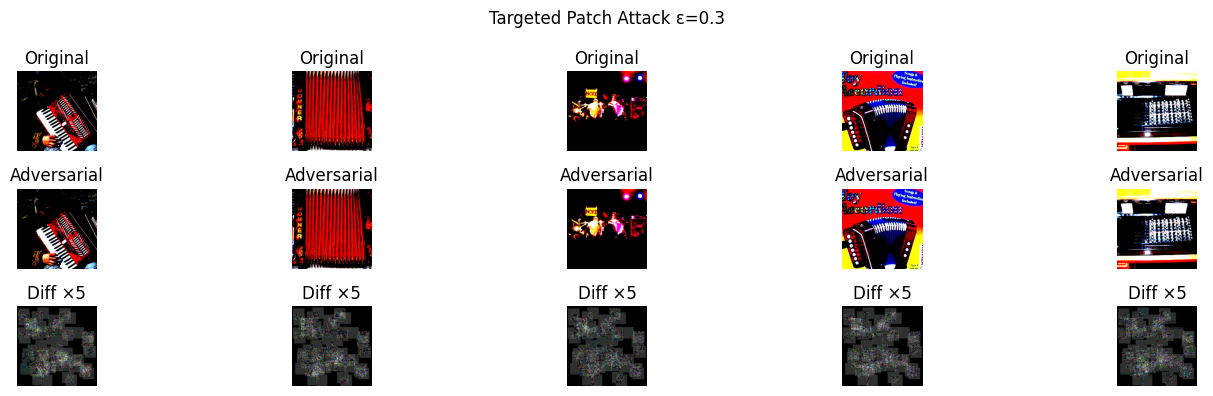

In [ ]:
show_adversarial_examples(test_loader, tpatch_adv_03, title="Targeted Patch Attack ε=0.3")

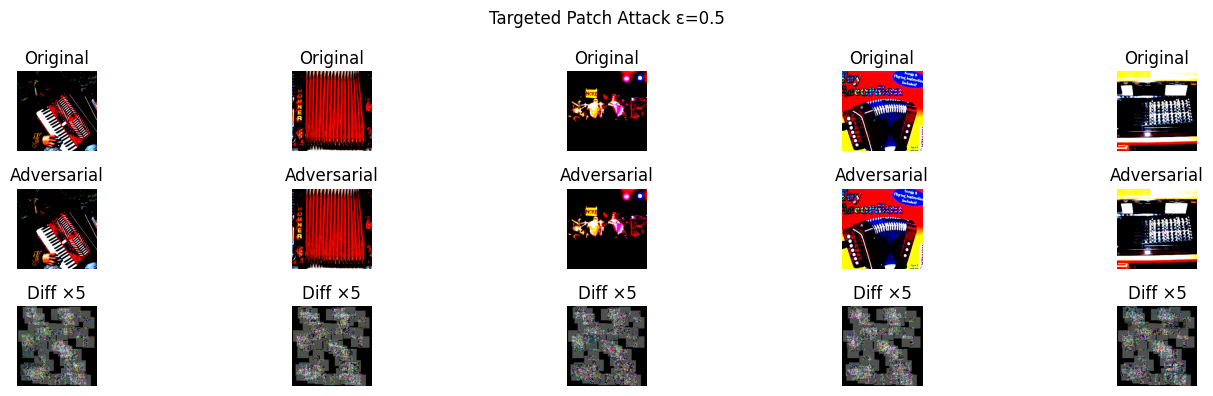

In [ ]:
show_adversarial_examples(test_loader, tpatch_adv_05, title="Targeted Patch Attack ε=0.5")

In [ ]:
save_adversarial_images(tpatch_adv_05, "AdversarialTestSet3/targeted", "patch")

In [ ]:
def untargeted_patch_attack(model, images, labels, epsilon, steps=50, patch_size=32):
    alpha = epsilon / steps
    mean = torch.tensor(mean_norms).reshape(1, 3, 1, 1).to(images.device)
    std = torch.tensor(std_norms).reshape(1, 3, 1, 1).to(images.device)

    raw = images * std + mean
    raw_orig = raw.clone().detach()

    _, _, H, W = raw.shape
    top = random.randint(0, H - patch_size)
    left = random.randint(0, W - patch_size)

    adv = raw.clone().detach()
    adv.requires_grad_()
    adv.retain_grad()

    for step in range(steps):
        norm_input = (adv - mean) / std
        outputs = model(norm_input)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward(retain_graph=True)

        grad = adv.grad
        grad_patch = grad[:, :, top:top+patch_size, left:left+patch_size]
        update = alpha * grad_patch.sign()

        patch = adv[:, :, top:top+patch_size, left:left+patch_size] + update
        orig_patch = raw_orig[:, :, top:top+patch_size, left:left+patch_size]

        clipped_patch = torch.clamp(patch, orig_patch - epsilon, orig_patch + epsilon)
        clipped_patch = torch.clamp(clipped_patch, 0, 1)

        # Replace the patch safely
        adv_new = adv.detach().clone()
        adv_new[:, :, top:top+patch_size, left:left+patch_size] = clipped_patch
        adv_new.requires_grad_()
        adv_new.retain_grad()
        adv = adv_new

        # Re-target patch region every 10 steps
        if (step + 1) % 10 == 0:
            top = random.randint(0, H - patch_size)
            left = random.randint(0, W - patch_size)

    return ((adv - mean) / std).detach()
def generate_untargeted_patch_attacks(epsilon):
    patch_advs = []
    for images, labels in tqdm(test_loader, desc=f"Patch ε={epsilon}"):
        images = images.cuda()
        mapped_labels = torch.tensor([imagenet_labels[int(lbl)] for lbl in labels]).cuda()
        adv = untargeted_patch_attack(model, images, mapped_labels, epsilon=epsilon)
        patch_advs.extend(adv.cpu())
    return patch_advs
utpatch_adv_03 = generate_untargeted_patch_attacks(0.3)
utpatch_adv_05 = generate_untargeted_patch_attacks(0.5)

evaluate_adv(model, utpatch_adv_03, test_loader, imagenet_labels, label="Patch Attack ε=0.3 (untargeted)")
evaluate_adv(model, utpatch_adv_05, test_loader, imagenet_labels, label="Patch Attack ε=0.5 (untargeted)")

Patch ε=0.5: 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]


[Patch Attack ε=0.3 (untargeted)] Top-1: 5.40%, Top-5: 37.60%
[Patch Attack ε=0.5 (untargeted)] Top-1: 3.60%, Top-5: 28.60%


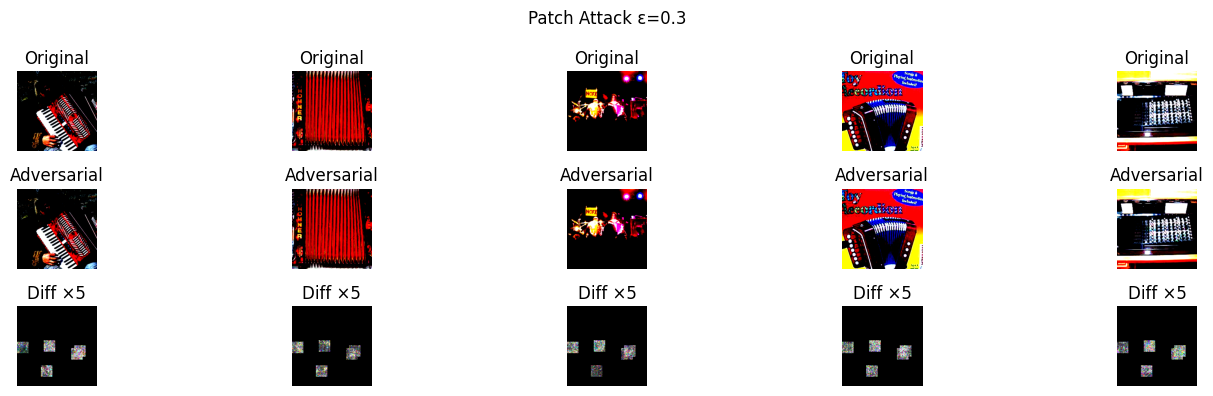

In [ ]:
show_adversarial_examples(test_loader, utpatch_adv_03, title="Patch Attack ε=0.3")

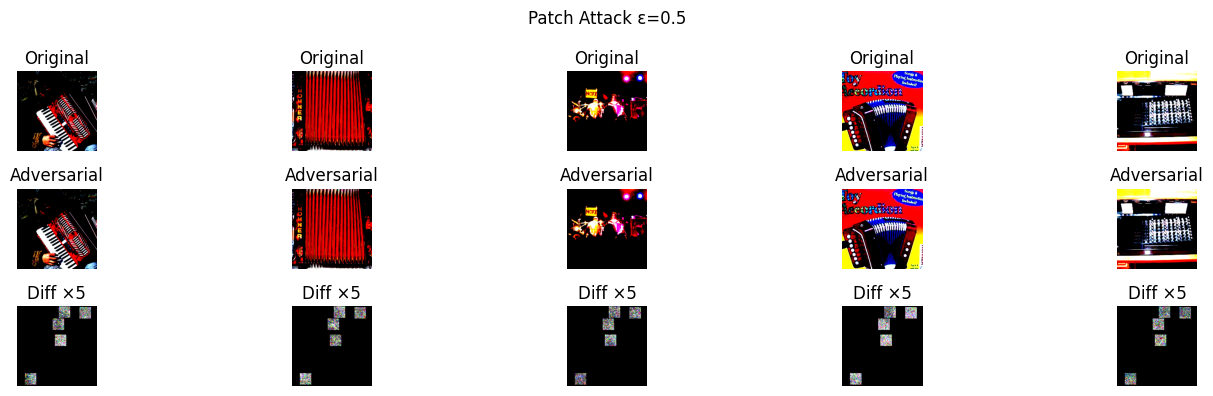

In [ ]:
show_adversarial_examples(test_loader, utpatch_adv_05, title="Patch Attack ε=0.5")

In [ ]:
save_adversarial_images(utpatch_adv_05, "AdversarialTestSet3/untargeted", "patch")

## Task 5: Transferability Analysis on DenseNet-121

To evaluate attack transferability, we run all 3 adversarial test sets (FGSM, PGD, Patch) on **DenseNet-121**, a different pretrained model.

This helps answer:
- How well do attacks generated on ResNet-34 transfer to other models?
- Which attacks generalize better?


In [ ]:
from torchvision.models import densenet121

densenet_model = densenet121(weights='IMAGENET1K_V1').cuda().eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 144MB/s]


In [ ]:
evaluate_model(densenet_model, test_loader, imagenet_labels)
evaluate_adv(densenet_model, fgsm_adv_raw, test_loader, imagenet_labels, label="FGSM → DenseNet-121")
evaluate_adv(densenet_model, pgd_adv, test_loader, imagenet_labels, label="PGD → DenseNet-121")
evaluate_adv(densenet_model, tpatch_adv_05, test_loader, imagenet_labels, label="Targeted Patch Attack ε=0.5 → DenseNet-121")
evaluate_adv(densenet_model, utpatch_adv_05, test_loader, imagenet_labels, label="Untargeted Patch Attack ε=0.5 → DenseNet-121")

100%|██████████| 16/16 [00:01<00:00,  8.48it/s]


Top-1 Accuracy: 74.60%
Top-5 Accuracy: 93.60%
[FGSM → DenseNet-121] Top-1: 45.60%, Top-5: 75.80%
[PGD → DenseNet-121] Top-1: 34.80%, Top-5: 73.20%
[Targeted Patch Attack ε=0.5 → DenseNet-121] Top-1: 69.60%, Top-5: 89.80%
[Untargeted Patch Attack ε=0.5 → DenseNet-121] Top-1: 62.20%, Top-5: 89.00%


We evaluated the transferability of adversarial attacks by testing all 3 adversarial datasets (FGSM, PGD, and patch attacks) on a new model — DenseNet-121.

**Summary of Results:**
- Accuracy dropped significantly under **FGSM and PGD attacks**, showing strong transferability.
- However, **patch-based attacks** had a much smaller impact on DenseNet-121 compared to ResNet-34.
- Top-5 accuracy remained high for patch attacks (~89%), suggesting that the model still retained some coarse-level robustness.

**Key Takeaways:**
- **Gradient-based attacks like PGD** transfer well across models.
- **Localized attacks like patch attacks** are less transferable due to architectural differences in feature extraction.
- **To mitigate transferability**, one could use adversarial training with diverse models or employ input preprocessing like JPEG compression or random resizing.


In [ ]:
!zip -r AdversarialTestSets.zip AdversarialTestSet1 AdversarialTestSet2 AdversarialTestSet3

  adding: AdversarialTestSet1/ (stored 0%)
  adding: AdversarialTestSet1/FGSM_422.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_115.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_210.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_163.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_150.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_288.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_309.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_419.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_049.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_039.png (deflated 1%)
  adding: AdversarialTestSet1/FGSM_478.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_433.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_305.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_247.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_071.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_381.png (deflated 0%)
  adding: AdversarialTestSet1/FGSM_332.png (d

In [ ]:
from google.colab import files
files.download("AdversarialTestSets.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Final Results Summary and Visualization

We compile all accuracy results into a single table and export it as `final_results.csv`.

Then we generate:
- **Bar plots** for Top-1 and Top-5 accuracy across attacks and models
- **Line plot** showing patch attack accuracy vs ε (on ResNet-34)

These visualizations clearly illustrate attack strength and transferability trends.

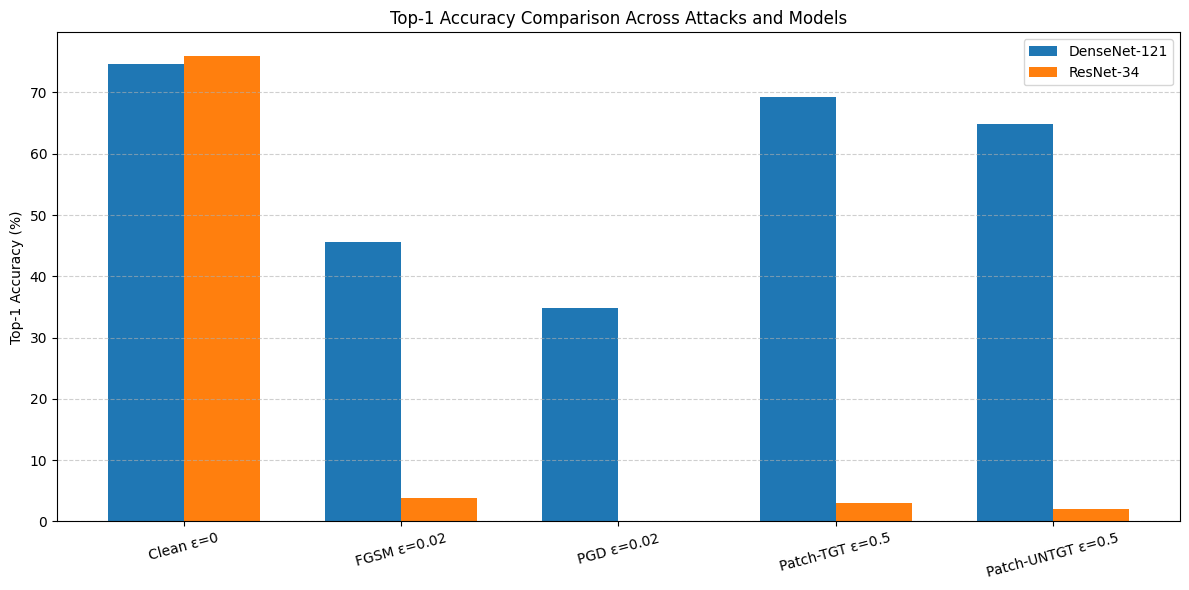

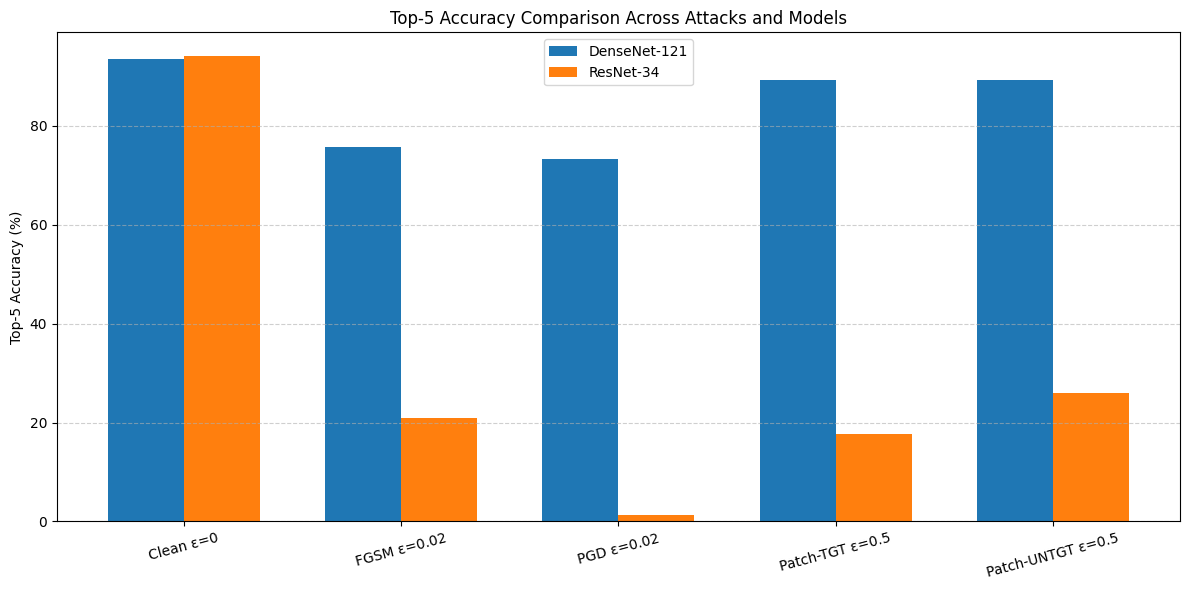

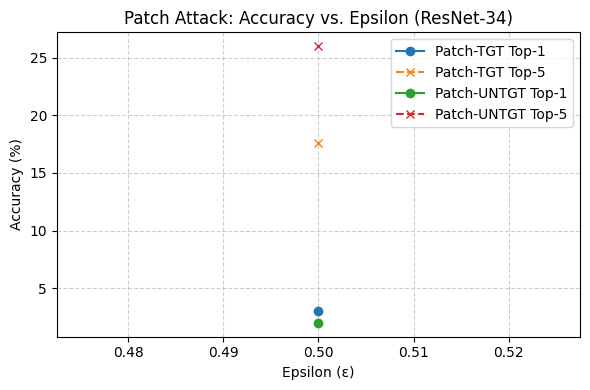

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

results = [
    # ResNet-34 baseline and attacks
    {"Attack": "Clean",       "Epsilon": "0",    "Model": "ResNet-34",    "Top-1": 76.00, "Top-5": 94.20},
    {"Attack": "FGSM",        "Epsilon": "0.02", "Model": "ResNet-34",    "Top-1": 3.80,  "Top-5": 21.00},
    {"Attack": "PGD",         "Epsilon": "0.02", "Model": "ResNet-34",    "Top-1": 0.00,  "Top-5": 1.40},
    {"Attack": "Patch-TGT",   "Epsilon": "0.5",  "Model": "ResNet-34",    "Top-1": 3.00,  "Top-5": 17.60},
    {"Attack": "Patch-UNTGT", "Epsilon": "0.5",  "Model": "ResNet-34",    "Top-1": 2.00,  "Top-5": 26.00},

    # DenseNet-121 baseline and transferred attacks
    {"Attack": "Clean",       "Epsilon": "0",    "Model": "DenseNet-121", "Top-1": 74.60, "Top-5": 93.60},
    {"Attack": "FGSM",        "Epsilon": "0.02", "Model": "DenseNet-121", "Top-1": 45.60, "Top-5": 75.80},
    {"Attack": "PGD",         "Epsilon": "0.02", "Model": "DenseNet-121", "Top-1": 34.80, "Top-5": 73.20},
    {"Attack": "Patch-TGT",   "Epsilon": "0.5",  "Model": "DenseNet-121", "Top-1": 69.20, "Top-5": 89.20},
    {"Attack": "Patch-UNTGT", "Epsilon": "0.5",  "Model": "DenseNet-121", "Top-1": 64.80, "Top-5": 89.20},
]

# === 2. Save to CSV and prepare labels ===
df = pd.DataFrame(results)
df["AttackLabel"] = df["Attack"] + " ε=" + df["Epsilon"]
df.to_csv("final_results.csv", index=False)

# === 3. Top-1 Accuracy Bar Plot ===
pivot_top1 = df.pivot(index="AttackLabel", columns="Model", values="Top-1").fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
x = range(len(pivot_top1))
for i, model in enumerate(pivot_top1.columns):
    ax.bar([p + i * bar_width for p in x], pivot_top1[model], width=bar_width, label=model)
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(pivot_top1.index, rotation=15)
ax.set_ylabel("Top-1 Accuracy (%)")
ax.set_title("Top-1 Accuracy Comparison Across Attacks and Models")
ax.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("final_accuracy_barplot.png")
plt.show()

# === 4. Top-5 Accuracy Bar Plot ===
pivot_top5 = df.pivot(index="AttackLabel", columns="Model", values="Top-5").fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
for i, model in enumerate(pivot_top5.columns):
    ax.bar([p + i * bar_width for p in x], pivot_top5[model], width=bar_width, label=model)
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(pivot_top5.index, rotation=15)
ax.set_ylabel("Top-5 Accuracy (%)")
ax.set_title("Top-5 Accuracy Comparison Across Attacks and Models")
ax.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("final_top5_accuracy_barplot.png")
plt.show()

# === 5. Line Plot: Patch Attack Accuracy vs Epsilon (ResNet-34 only) ===
patch_df = df[(df["Attack"].isin(["Patch-TGT", "Patch-UNTGT"])) & (df["Model"] == "ResNet-34")]
fig, ax = plt.subplots(figsize=(6, 4))
for attack_type in patch_df["Attack"].unique():
    subset = patch_df[patch_df["Attack"] == attack_type]
    ax.plot(subset["Epsilon"].astype(float), subset["Top-1"], marker='o', label=f"{attack_type} Top-1")
    ax.plot(subset["Epsilon"].astype(float), subset["Top-5"], marker='x', linestyle='--', label=f"{attack_type} Top-5")
ax.set_xlabel("Epsilon (ε)")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Patch Attack: Accuracy vs. Epsilon (ResNet-34)")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("patch_accuracy_vs_epsilon.png")
plt.show()